# Analysing results of NAMD simulations using MLatom
Author: Mikołaj Martyka

This tutorial shows how to analyse results of NAMD simulations and extract data from an ensamble of trajectories. 
The data used in this tutorial is available at this DOI: 10.6084/m9.figshare.28044863
Taken from our paper on active learning for TSH simulations, available at: https://chemrxiv.org/engage/chemrxiv/article-details/66e7e01712ff75c3a177a270

In [1]:
import mlatom as ml


## Example 1: Analysis of the hopping geometries in fulvene
As a first example we will analyse hopping geometries of fulvene, after excitation to S1. Reference, eg. doi.org/10.12688/openreseurope.13624.2

In [2]:
#Define a function for extracting hopping geometries.
def get_hop_geos(traj):
        nstates = len(traj.steps[0].molecule.electronic_states)
        local_hop_list = [[ [] for k in range(nstates)] for j in range(nstates)]
        for index, geom in enumerate(traj.steps):
            if index !=0:
                if geom.current_state != traj.steps[index-1].current_state:
                    hop_to = int(geom.current_state)
                    hop_from = int(traj.steps[index-1].current_state)
                    traj.steps[index-1].molecule.hoptime = traj.steps[index-1].time
                    print
                    local_hop_list[hop_from][hop_to].append(traj.steps[index-1].molecule)

        geoms = []  
        for k in range(nstates):
            for j in range(nstates):
                if local_hop_list[k][j] != None:
                    for idx, hop_geom in enumerate(local_hop_list[k][j]):
                        hop_geom.hop_from = k
                        hop_geom.hop_to = j
                        geoms.append(hop_geom)
        return geoms


In [3]:
#Load a fulvene molecule in MLatom format
mol = ml.data.molecule.load("eqmol.json", format='json')


In [4]:
#Check what is the numbering of the atoms in the xyz file
mol.write_file_with_xyz_coordinates("fulvene.xyz")
mol.view()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
#Define lists for the relevant quantities
C_CH2_lens = [] #The bond length between atoms no. 0 and 5
#The four dihedral angles required for eq. (8)
C_CH2_dihedral_Cis1= []
C_CH2_dihedral_Cis2 = []
C_CH2_dihedral_trans1 = []
C_CH2_dihedral_trans2 = []
#List for hop times
hop_times = []

In [6]:
#Iterate over trajectories...
for i in range(50):
    #...load them...
    traj = ml.data.molecular_trajectory()
    traj.load("traj{}.json".format(i+1), format='json')
    #...extract hop geoms...
    hop_geoms = get_hop_geos(traj)
    #...and finally extract the data.
    for mol in hop_geoms:
        C_CH2_lens.append(mol.bond_length(0, 5))
        C_CH2_dihedral_Cis1.append(mol.dihedral_angle(2, 0, 5,10))
        C_CH2_dihedral_Cis2.append(mol.dihedral_angle(1, 0, 5,11))
        C_CH2_dihedral_trans1.append(mol.dihedral_angle(2, 0, 5,11))
        C_CH2_dihedral_trans2.append(mol.dihedral_angle(1, 0, 5,10))
        hop_times.append(mol.hoptime)
        
        


    
    

In [7]:
#Calculate the mean dihedral angle according to  Barbatti et al Open. Res. Eur. 2022, 1, 49.
hop_angle = []
for i in range(len(C_CH2_dihedral_Cis1)):
    sum1 = abs(C_CH2_dihedral_Cis1[i])+abs(C_CH2_dihedral_Cis2[i])+abs(180-abs(C_CH2_dihedral_trans1[i]))+abs(180-abs(C_CH2_dihedral_trans2[i]))
    hop_angle.append(0.25*sum1)

In [8]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Mean C=CH2 dihedral (degrees)')

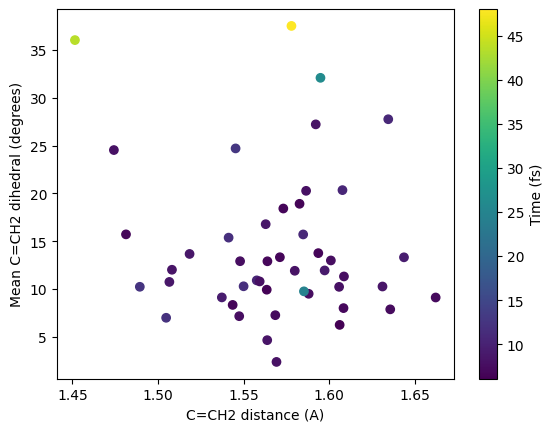

In [9]:
#Plot the results, using the hopping times as a colormap. See fig 5 of 10.26434/chemrxiv-2024-dtc1w-v2 for a plot with more points and explanation.
plt.scatter(C_CH2_lens, hop_angle, c=hop_times)
cbar = plt.colorbar()
cbar.set_label('Time (fs)')
plt.xlabel("C=CH2 distance (A)")
plt.ylabel("Mean C=CH2 dihedral (degrees)")


## Example 2: Analysis of the quantum yield of cis -> trans photoisomerization of azobenzene
Now we will calculate the quantum yield (QY) of azobenzene cis -> trans isomerisation. Reference: 10.26434/chemrxiv-2024-dtc1w-v2, fig. 7 and text.

In [10]:
#list for dihedral angles
dih_fin = []

In [11]:
#Iterate over trajectories
for i in range(50):
    #Load the final geometries of each trajectory. Notice that the format and location is different, this is the typical output of MLatom's run_in_parallel.
    traj = ml.data.molecular_trajectory()
    traj.load("job_surface_hopping_md_{}/traj.h5".format(i+1), format='h5md')
    #Take the final geometry in each trajectory...
    finmol = traj.steps[-1].molecule
    #...and the dihedral angle.
    dih_fin.append(finmol.dihedral_angle(11, 23, 22,3))

In [12]:
#View one representative trajectory 
traj.view()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Text(0.5, 0, 'Dihedral angle (Deg.)')

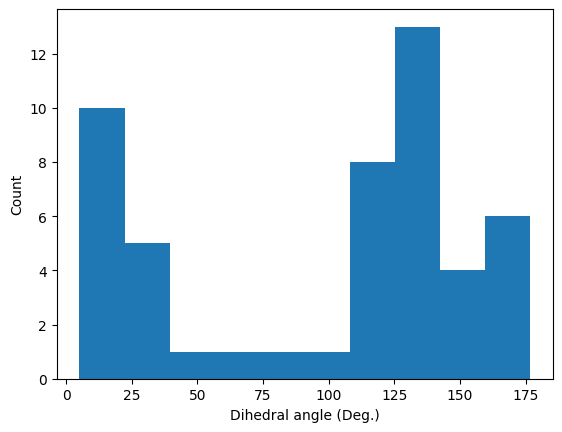

In [13]:
#Plot a histogram of the dihedral angles
plt.hist(dih_fin)
plt.ylabel("Count")
plt.xlabel("Dihedral angle (Deg.)")

In [14]:
#Count the number of trans-azobenzenes at the end, taking the descriptor of dihedral >60 as trans-azobenzene.
counter = 0
for angle in dih_fin:
    if angle > 60:
        counter+=1

In [15]:
#Print the QY
QY = counter/50*100
print("The quantum yield is {}%!".format(QY))

The quantum yield is 68.0%!
